<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
This notebook is designed specially for the module

ET5003 - MACHINE LEARNING APPLICATIONS 

Instructor: Enrique Naredo
###ET5003_DeepNN

© All rights reserved to the author, do not share outside this module.


## Introduction

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

**Acknowledgement**

This notebook is refurbished taking source code from Alessio Benavoli's webpage and from the libraries numpy, GPy, pylab, and pymc3.

## Libraries

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://pypi.org/project/GPy/
!pip install gpy

     |████████████████████████████████| 959 kB 2.7 MB/s 
     |████████████████████████████████| 71 kB 7.6 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565106 sha256=fc2ce0ce69e5f408c40b7f877689587dc1b6c2f7a4d562ab4a2c1fc002a2112e
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=2d3dfddad62eff4cd1ec63d39840d695fc81e66a1e075d7951077cb1e4b84a67
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [3]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

## Data generation
Generate data from a nonlinear function and use a Gaussian Process to sample it.

In [4]:
# seed the legacy random number generator
# to replicate experiments
seed = None
#seed = 7
np.random.seed(seed)

In [5]:
# Gaussian Processes
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
# Radial Basis Functions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# kernel is a function that specifies the degree of similarity 
# between variables given their relative positions in parameter space
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [6]:
# number of samples
num_samples_train = 250 
num_samples_test = 200

# intervals to sample
a, b, c = 0.2, 0.6, 0.8
# points evenly spaced over [0,1]
interval_1 = np.random.rand(int(num_samples_train/2))*b - c
interval_2 = np.random.rand(int(num_samples_train/2))*b + c

X_new_train = np.sort(np.hstack([interval_1,interval_2])) 
X_new_test  = np.linspace(-1,1,num_samples_test)

X_new_all = np.hstack([X_new_train,X_new_test]).reshape(-1,1)

# vector of the means
μ_new = np.zeros((len(X_new_all)))
# covariance matrix
C_new = kernel.K(X_new_all,X_new_all)

# noise factor
noise_new = 0.1

# generate samples path with mean μ and covariance C
TF_new = np.random.multivariate_normal(μ_new,C_new,1)[0,:]
y_new_train = TF_new[0:len(X_new_train)] + np.random.randn(len(X_new_train))*noise_new
y_new_test = TF_new[len(X_new_train):] + np.random.randn(len(X_new_test))*noise_new
TF_new = TF_new[len(X_new_train):]

In this example, first generate a nonlinear functions and then generate noisy training data from that function.

The constrains are:
* Training samples $x$ belong to either interval $[-0.8,-0.2]$ or $[0.2,0.8]$.
* There is not data training samples from the interval $[-0.2,0.2]$. 
* The goal is to evaluate the extrapolation error outside in the interval  $[-0.2,0.2]$.

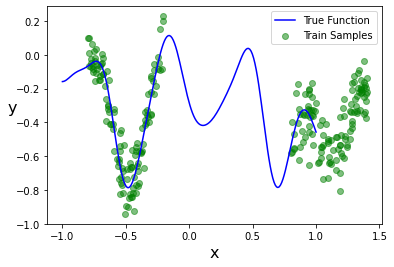

In [7]:
# plot 
pb.figure()
pb.plot(X_new_test,TF_new,c='b',label='True Function',zorder=100)
# training data
pb.scatter(X_new_train,y_new_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16);
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("New_data.pdf")

## Deep Neural Networks

In [29]:
def computeL(X,W):
    """
    Compute L matrix for a single-layer NN
    as in linear regression
    X is the set of samples
    W is a matrix of weights 
    Return the matrix L
    """

    # activation function
    # compute hyperbolic tangent element-wise
    def ϕ(x,w):
        return np.tanh( w[:,0] + x*w[:,1] ) 

    L = []
    # loop to create matrix L
    for i in range(len(X)):
        L.append(ϕ(X[i],W))

    # create a numpy array 
    L = np.array(L)
    
    # column with ones
    O = np.ones((L.shape[0],1))
    # add a column with ones to L
    L = np.hstack([O,L])

    # return the L matrix
    return L

In [30]:
def leastsquares(X,y):
    """
    Computes the Least Squares (LS) method
    https://en.wikipedia.org/wiki/Least_squares
    """
    # machine epsilon 
    # https://en.wikipedia.org/wiki/Machine_epsilon
    # for float values can be obtained by typing
    eps = np.finfo(float).eps

    # we add this epsilon to avoid numerical problems when we invert the matrix
    # linalg-> linear algebra functions
    M = np.linalg.inv(np.matmul(X.T,X) + eps*np.identity(X.shape[1]))

    # matmul-> matrix product of two arrays
    # X.T-> transposed array
    # https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T
    theta = np.matmul(M, np.matmul(X.T,y) )
    return theta

In [46]:
# hu-> hidden units
hu = 50 

In [47]:
# generate random weights for 2 inner layers
W = np.random.randn(hu,2) 
print(W)

[[ 1.65069969  0.15433554]
 [-0.38713994  2.02907222]
 [-0.04538603 -1.4506787 ]
 [-0.40522786 -2.2883151 ]
 [ 1.04939655 -0.41647432]
 [-0.74255353  1.07247013]
 [-1.65107559  0.53542936]
 [-2.0644148  -0.66215934]
 [-1.20421985  1.46197563]
 [ 1.76616088 -0.32941375]
 [ 0.84073324 -0.1799864 ]
 [ 0.56806189 -0.7528372 ]
 [-1.7083392  -1.80309866]
 [ 0.38312185  2.24759505]
 [ 0.26941163 -0.52460462]
 [ 1.91201886  0.23730185]
 [ 0.10143399  0.25257774]
 [-0.1323772  -0.30947634]
 [-1.43496347  0.50162412]
 [-0.09477545  1.19308592]
 [-0.36881847 -1.90636988]
 [-0.09961063  1.6995373 ]
 [-0.38342312 -0.88985686]
 [-1.19359192 -1.05001681]
 [-0.30019374 -1.17998209]
 [ 1.49763912 -0.28263524]
 [ 0.10864837  1.43823952]
 [ 1.50331852 -0.21273297]
 [ 0.33197422  0.73502658]
 [-0.19285546 -1.77801285]
 [ 0.6547057   0.8943523 ]
 [ 0.41550261 -0.92354466]
 [-0.19602731 -0.59076982]
 [-0.29971124  1.29688519]
 [ 1.52957963  0.66941819]
 [ 0.54874512  0.67662899]
 [-0.01224219 -0.07566346]
 

In [48]:
# train: compute H matrix as in linear regression
DNN_train = computeL(X_new_train,W)
print(DNN_train)

[[ 1.          0.90999425 -0.96451764 ... -0.88084748  0.34941528
  -0.96695762]
 [ 1.          0.91014909 -0.96368201 ... -0.88060785  0.34721321
  -0.96628763]
 [ 1.          0.91024334 -0.96316326 ... -0.88046157  0.3458692
  -0.96587275]
 ...
 [ 1.          0.9532593   0.98514776 ... -0.75219703 -0.52062815
   0.94611937]
 [ 1.          0.95328326  0.98524917 ... -0.75206193 -0.52115992
   0.94643018]
 [ 1.          0.95329787  0.98531069 ... -0.75197948 -0.52148409
   0.9466189 ]]


In [49]:
# array shapes
X_new_train.shape, W.shape, DNN_train.shape

((250,), (50, 2), (250, 51))

In [50]:
# estimate weights θ for the outer layer (linear layer)
θ_ol = leastsquares(DNN_train,y_new_train)
print(θ_ol)

[-2.63905688e+05  7.14979031e+05  3.97990805e+05  2.02730925e+06
  1.18560033e+06  1.73533364e+06 -4.26590500e+05 -2.94054688e+05
  5.89800758e+05 -2.90056562e+04 -7.38723328e+05 -8.25658625e+05
  5.78495562e+05 -3.78215625e+03  1.21150325e+06  8.14773188e+05
 -3.20939941e+05 -1.15078475e+06 -6.89620581e+06 -1.28213203e+05
 -2.66744206e+06 -1.77465635e+05 -4.19235062e+05 -1.08862556e+06
  1.01354828e+06 -6.85463516e+05  5.72247461e+05 -4.16137312e+05
 -4.46364227e+05  2.30238188e+05 -1.38100312e+06  1.18263684e+06
 -1.84683200e+06  2.42224331e+06  1.17709583e+06  6.73588438e+04
 -1.76638694e+06 -7.66962756e+06  7.29332089e+05 -4.76935043e+05
 -3.37445875e+05  4.38368617e+05 -3.99591844e+05 -1.68339125e+05
  2.07338492e+05 -2.37332375e+05 -1.66831238e+06  8.57087500e+05
  7.25239844e+04  9.72475438e+05  5.15065156e+04]


In [51]:
# test: compute H matrix as in linear regression
DNN_test = computeL(X_new_test,W)

In [52]:
# predictions
y_pred = np.matmul(DNN_test,θ_ol)
print(y_pred)

[-2.12003662e+02 -1.76666159e+02 -1.45960418e+02 -1.19424249e+02
 -9.66250574e+01 -7.71594317e+01 -6.06526210e+01 -4.67579166e+01
 -3.51559380e+01 -2.55538287e+01 -1.76843683e+01 -1.13050062e+01
 -6.19682570e+00 -2.16344287e+00  9.70148779e-01  3.35878156e+00
  5.13835503e+00  6.42710686e+00  7.32690363e+00  7.92454205e+00
  8.29305092e+00  8.49298418e+00  8.57369546e+00  8.57458463e+00
  8.52630738e+00  8.45193893e+00  8.36808379e+00  8.28592385e+00
  8.21219807e+00  8.15010762e+00  8.10014143e+00  8.06081814e+00
  8.02934150e+00  8.00216745e+00  7.97548256e+00  7.94559443e+00
  7.90923647e+00  7.86379023e+00  7.80743021e+00  7.73919697e+00
  7.65900573e+00  7.56759838e+00  7.46644796e+00  7.35762529e+00
  7.24363768e+00  7.12725017e+00  7.01129974e+00  6.89851225e+00
  6.79133199e+00  6.69177210e+00  6.60129364e+00  6.52071936e+00
  6.45018661e+00  6.38914211e+00  6.33637924e+00  6.29011650e+00
  6.24811339e+00  6.20781841e+00  6.16654125e+00  6.12164010e+00
  6.07071296e+00  6.01178

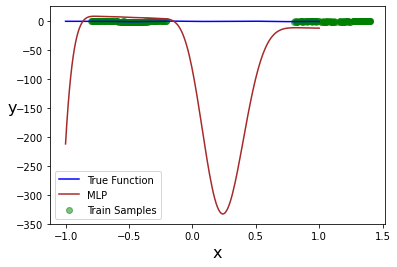

In [53]:
# plot all together
pb.plot(X_new_test,TF_new,c='b',label='True Function')
pb.plot(X_new_test,y_pred,c='brown',label='MLP')
pb.scatter(X_new_train,y_new_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()

# save temporarily to drive
pb.savefig("MLP_pred_1.pdf") 

In [62]:
# start with 250 epochs, then increase them to 25000 or more?
num_epochs = 25000

# batch size
batch_size = 200

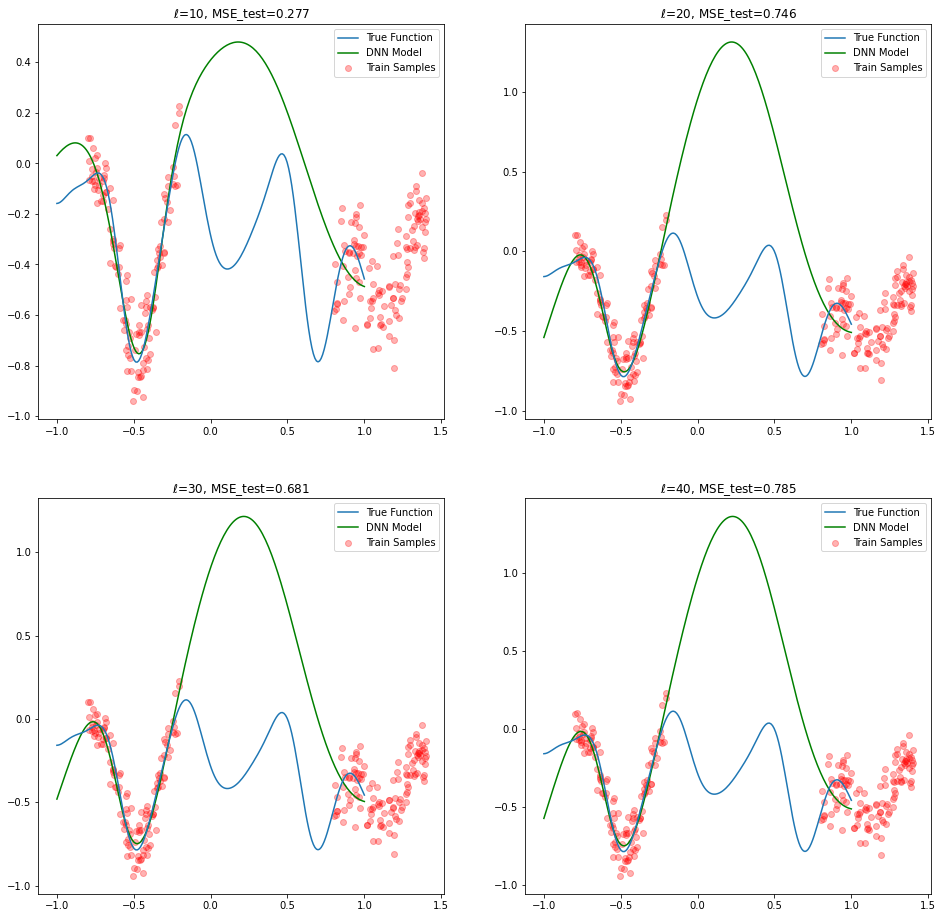

In [63]:
# figure with subplots 
fig, axs = pb.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# ravel-> return a contiguous flattened array
# https://numpy.org/doc/stable/reference/generated/numpy.ravel.html
axs = axs.ravel()

# first index
ax_index = 0


# loop in the hidden units
for i in range(10,hu,10):   

    # Sequential-> groups a linear stack of layers into a tf.keras.Model
    model = Sequential()

    # inner layer
    # Dense implements the operation: output = activation(dot(input, kernel) + bias)
    model.add(Dense(i, input_dim=1, kernel_initializer='normal', activation='tanh', name='input_layer'))

    # outer linear layer
    model.add(Dense(1, kernel_initializer='normal', activation='linear', name='output_layer'))

    # compile model
    # configure the model for training
    # mse = tf.keras.losses.MeanSquaredError()
    # https://keras.io/api/losses/regression_losses/#mean_squared_error-function
    # adam-> optimizer, https://keras.io/api/optimizers/
    model.compile(loss='mse', optimizer='adam')

    # fit model: train the model for a fixed number of epochs
    model.fit(X_new_train, y_new_train, epochs=num_epochs, batch_size=batch_size, verbose=0)

    # predictions
    y_pred2 = model.predict(X_new_test)

    # MSE-> Mean Squared Error in test set
    MSE_test = np.round( np.mean( (y_pred2 - y_new_test)**2 ), 3)

    # plots
    axs[ax_index].plot(X_new_test,TF_new,zorder=100,label='True Function')
    axs[ax_index].plot(X_new_test,y_pred2,c='green',label='DNN Model')
    axs[ax_index].scatter(X_new_train,y_new_train,c='r',label='Train Samples',alpha=0.3)
    axs[ax_index].set_title('$\ell$='+str(i)+', MSE_test='+str(MSE_test) )
    axs[ax_index].legend()

    # index counter
    ax_index = ax_index+1

# save temporarily to drive
pb.savefig("DNN Model.pdf", bbox_inches='tight')